# Predictive Maintenance -  Proof of Concept

## Data description

<p> The data set was experimentally obtained with a hydraulic test rig. This test rig consists of a primary working and a secondary cooling-filtration circuit which are connected via the oil tank. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows and temperatures while the condition of four hydraulic components (cooler, valve, pump and accumulator) is quantitatively varied. 

Attribute Information:
The data set contains raw process sensor data (i.e. without feature extraction) which are structured as matrices (tab-delimited) with the rows representing the cycles and the columns the data points within a cycle. The sensors involved are:
Sensor		Physical quantity		Unit		Sampling rate
PS1		Pressure			bar		100 Hz
PS2		Pressure			bar		100 Hz
PS3		Pressure			bar		100 Hz
PS4		Pressure			bar		100 Hz
PS5		Pressure			bar		100 Hz
PS6		Pressure			bar		100 Hz
EPS1		Motor power			W		100 Hz
FS1		Volume flow			l/min		10 Hz
FS2		Volume flow			l/min		10 Hz
TS1		Temperature			°C		1 Hz
TS2		Temperature			°C		1 Hz
TS3		Temperature			°C		1 Hz
TS4		Temperature			°C		1 Hz
VS1		Vibration			mm/s		1 Hz
CE		Cooling efficiency (virtual)	%		1 Hz
CP		Cooling power (virtual)		kW		1 Hz
SE		Efficiency factor		%		1 Hz

The target condition values are cycle-wise annotated in profile.txt (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %:
	3: close to total failure
	20: reduced effifiency
	100: full efficiency

2: Valve condition / %:
	100: optimal switching behavior
	90: small lag
	80: severe lag
	73: close to total failure

3: Internal pump leakage:
	0: no leakage
	1: weak leakage
	2: severe leakage

4: Hydraulic accumulator / bar:
	130: optimal pressure
	115: slightly reduced pressure
	100: severely reduced pressure
	90: close to total failure

5: stable flag:
	0: conditions were stable
	1: static conditions might not have been reached yet
    
Dataset can be obtained here : https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems#
</p>

# Part 1 : Cooler condition prediction

<p> I chose to start working with Temperature related data. My features will be the temperature sensors, and my label will be the valve condition value. 
    
First step will be to concatenate all 4 temperature sensors, so I will have 4 * 60 = 240 features per cycle (or row/instance). 

I will then load the cooler condition feature from profile.txt, and I will shift all rows so my model can predict in the future. If I want to predict a failure 1 hour ahead, I will replace every value of cooling[T] by the value cooling[T+60]. 

I will then drop the last 60 rows of my label dataset because it is not possible to shift them, and also drop the last 60 rows from the sensors. 
</p> 

In [47]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random
RANDOM_SEED=random.randint(1,500)

#training data files
ts_files = ['TS1.txt', 'TS2.txt', 'TS3.txt', 'TS4.txt']
ps_files = ['PS1.txt', 'PS2.txt', 'PS3.txt', 'PS4.txt', 'PS5.txt', 'PS6.txt']
vl_files = ['FS1.txt', 'FS2.txt']
X = pd.DataFrame()
sensor=1
nb_data_points = np.arange(1,61)
for f in ts_files:
    #create array of header values
    header = []
    for dp in nb_data_points:
        header.append('sensor n°'+str(sensor)+'(t='+str(dp)+')')
    #load df and apply the header
    df = pd.read_csv('data/'+f, sep='\t', header=None, names=header)
    #add current file to final feature dataset
    for cols in list(df.columns.values):
        X[cols] = df[cols]
    sensor = sensor+1
#load profile.csv
y = pd.read_csv('data/profile.csv', sep='\t',header=None,names=['cooler','valve','pump','hydraulic','flag'])
#0 = Failure, 1 = Reduced efficiency, 2 = Full efficiency
y['cooler'] = y['cooler'].map({3:0, 20:1, 100:2}).astype(int)
#1 hour lag
lag = 60
y['cooler+'+str(lag)] = 0
y['flag+'+str(lag)] = 0
for index, row in y.iterrows():
    #prevent index out of range
    if index < (len(y)-(lag)):
        y['cooler+'+str(lag)][index] = y['cooler'][index+lag]
        y['flag+'+str(lag)][index] = y['flag'][index+lag]
rows_to_drop = np.arange(len(y)-(lag),len(y))
print(y.shape)
y = y.drop(rows_to_drop,axis=0)
X = X.drop(rows_to_drop,axis=0)
print(y.shape)
print(X.shape)

(2205, 7)
(2145, 7)
(2145, 240)


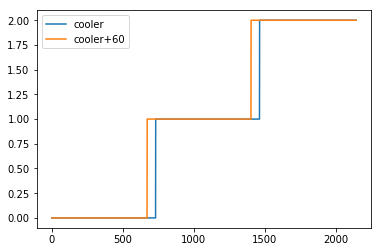

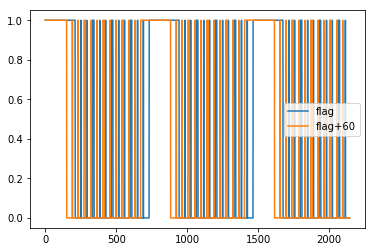

In [23]:
y[['cooler','cooler+'+str(lag)]].plot()


<p> Here I will normalize sensor data X to help the model, then I will add the label feature to X for training purposes, split the dataset in training and testing datasets, and drop the label from the testing dataset</p>

In [48]:


scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns.values)

msk = np.random.rand(len(scaled_X)) < 0.8

train_X = scaled_X[msk]
train_y = y['cooler+'+str(lag)][msk]

test_X = scaled_X[~msk]
test_y = y['cooler+'+str(lag)][~msk]

print(train_X.shape)
print(test_X.shape)

print(test_y.shape)

(1712, 240)
(433, 240)
(433,)


In [19]:

decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(train_X, train_y)
predictions = decision_tree.predict(test_X)

print(accuracy_score(test_y, predictions))

0.930648769574944


<p> As well as accuracy, I will show the confusion matrix. 
    
    0 = Failure, 
    
    1 = Reduced efficiency, 
    
    2 = Full efficiency
</p>

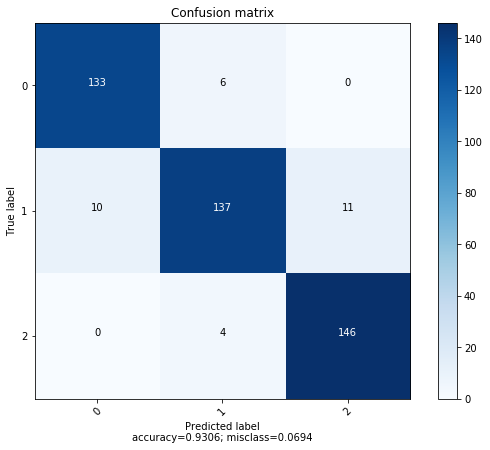

In [20]:


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
matrix = metrics.confusion_matrix(test_y, predictions)
plot_confusion_matrix(matrix,y.cooler.unique(),normalize=False)

In [49]:
from keras.utils import to_categorical
train_X, test_X = np.array(train_X),np.array(test_X)
train_y = to_categorical(train_y, num_classes=3)
test_y = to_categorical(test_y, num_classes=3)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1712, 240, 1)
(433, 240, 1)
(1712, 3)
(433, 3)


In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.utils import np_utils
from keras.models import Model

model = Sequential()
model.add(Conv1D(100, 6, activation='relu', input_shape=(240,1,)))
model.add(Conv1D(100, 6, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 6, activation='relu'))
model.add(Conv1D(160, 6, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_X, train_y, batch_size=32,
                    epochs=10, validation_split=0.2, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 235, 100)          700       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 230, 100)          60100     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 76, 100)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 71, 160)           96160     
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 66, 160)           153760    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 160)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 160)               0         
__________

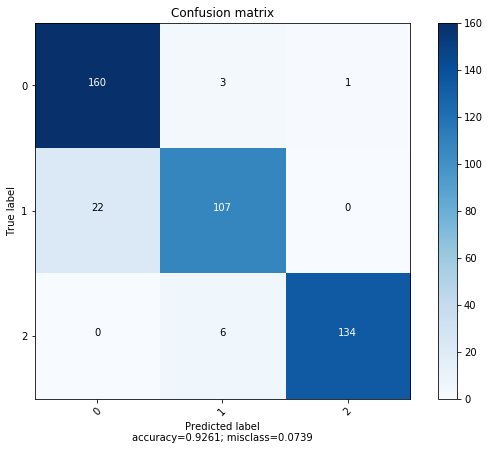

In [53]:
predictions = model.predict(test_X)
label = []
for p in predictions:
    maximum = np.max(p)
    label.append(np.where(maximum == p)[0])
true_label = []
for l in test_y:
    maximum = np.max(l)
    true_label.append(np.where(maximum == l)[0])
matrix = metrics.confusion_matrix(true_label, label)
plot_confusion_matrix(matrix,y.cooler.unique(),normalize=False)

# Part 2 : Flag prediction with temperature

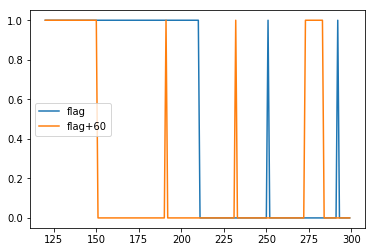

In [29]:
y[['flag','flag+'+str(lag)]][120:300].plot()

In [30]:
train_X = scaled_X[msk]
train_y = y['flag+'+str(lag)][msk]

test_X = scaled_X[~msk]
test_y = y['flag+'+str(lag)][~msk]


In [31]:

decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(train_X, train_y)
predictions = decision_tree.predict(test_X)

print(accuracy_score(test_y, predictions))

0.8210290827740492


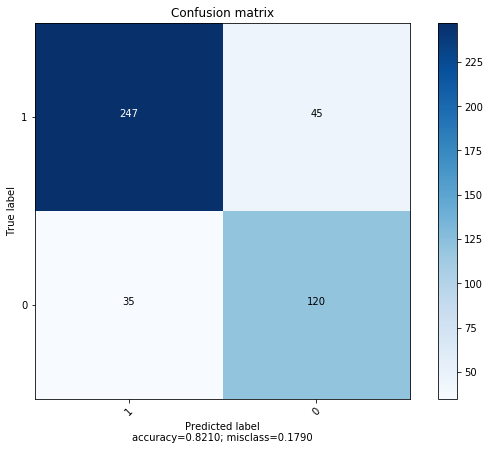

In [33]:
matrix = metrics.confusion_matrix(test_y, predictions)
plot_confusion_matrix(matrix,y.flag.unique(),normalize=False)